In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from os import listdir
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import euclidean_distances
import json
import re

In [2]:
# update the boundaries as we determined based on our hypothesis testing
def determine_period(row):
    if row <= 1695:
        period = 1
    elif row >= 1696 and row <= 1795:
        period = 2
    else:
        period = 3
    
    return period

In [3]:
def make_list(row):
    speech_dist = []
    for value in row[1:-1].split('\n '):
        speech_dist.append([int(num) for num in re.findall('[0-9]+', value)])
        
    return speech_dist

In [4]:
def speech_distribution_by_period(period_df):
    all_distributions = []
    for row in period_df['speech_distribution']:
        speech_dist_df = pd.DataFrame(row).T
        # rename columns to make sure they start with 1 and not 0
        speech_dist_df.columns = speech_dist_df.iloc[0, :]
        # no need to include the variants as a row - they will be column names
        only_counts_df = pd.DataFrame(speech_dist_df.iloc[1, :])
        only_counts_df.columns = ['raw_numbers']
        only_counts_df['percentage'] = only_counts_df['raw_numbers'] / only_counts_df.sum().values[0]
        all_distributions.append(round(only_counts_df['percentage'], 4))
        
    period_df_dist = pd.concat(all_distributions, axis=1).fillna(0)
    # take the mean for each period
    mean_per_type = pd.DataFrame(period_df_dist.mean(axis=1)).T 
    mean_per_type = (mean_per_type * 100).round(2)
    mean_per_type.index = ['percentage_of_scenes']
    mean_per_type.index.name = 'number_of_speakers'
    
    return mean_per_type

In [5]:
def sigma_iarkho(variants, weights):
    """
    The function allows calculating standard range following iarkho's procedure.
    Parameters:
        variants - a list with distinct variants in the ascending order, e.g. [1, 2, 3, 4, 5]
        weights - a list of weights corresponding to these variants, e.g. [20, 32, 18, 9, 1]
    Returns:
        sigma - standard range per iarkho
    """
    weighted_mean_variants = np.average(variants, weights=weights)
    differences_squared = [(variant - weighted_mean_variants)**2 for variant in variants]
    weighted_mean_difference = np.average(differences_squared, weights=weights)
    sigma = weighted_mean_difference**0.5

    return sigma

In [6]:
def coefficient_unused_dramatic_characters(data):
    total_present = 0
    total_non_speakers = 0
    for act in data['play_summary'].keys():
        for scene in data['play_summary'][act].keys():
            # identify the raw number of non-speaking dramatic characters
            num_non_speakers = len([item for item in data['play_summary'][act][scene].items() 
                                if (item[1] == 0  or item[1] == 'non_speaking') and item[0] not in ['num_utterances',
                                                                   'num_speakers',
                                                                   'perc_non_speakers']])
            total_non_speakers += num_non_speakers
            # calculate the total number of dramatic characters
            total_present += (data['play_summary'][act][scene]['num_speakers'] + num_non_speakers)
    coefficient_unused = (total_non_speakers / total_present ) * 100        
    
    return coefficient_unused

In [7]:
def get_data(input_directory):
    all_files = [f for f in listdir(input_directory) if f.count('.json') > 0]
    dfs = []
    for file in all_files:
        with open(input_directory + '/' + file) as json_file:
            data = json.load(json_file)
            not_used = coefficient_unused_dramatic_characters(data)
            df = pd.DataFrame([not_used], columns=['coefficient_unused'], index=[file.replace('.json','')])
            dfs.append(df)
            
    features_df = pd.concat(dfs, axis=0, sort=False).round(2)
    
    return features_df

In [8]:
def plot_speech_distribution(speech_dist_df, title):
    plt.figure(figsize=(10, 5))
    plt.title(title, fontsize=14)
    sns.barplot(speech_dist_df.columns.tolist(), 
                speech_dist_df.values.tolist()[0])
    plt.xlabel('Number of Speakers', fontsize=12)
    plt.ylabel('Percentage of Scenes', fontsize=12)

    plt.show()

#### Load and Process French Data

In [9]:
# read the data
french_data = pd.read_csv('../French_Comedies/Data/French_Comedies_Data.csv')
# read the sample data
french_sample_df = pd.read_csv('../French_Comedies/Data/French_Comedies_Data_Sample.csv')

# exclude the comedies used for the sample analysis
not_sample = french_data[~french_data['index'].isin(french_sample_df['index'])].copy()

# include only five act comedies and only the comedies that are not translations/adaptations 
french_original_comedies = not_sample[(not_sample['num_acts'] ==5)&
                               (not_sample['translation/adaptation/contrastive'] == 0)].copy()

# sort by date
french_sorted_comedies = french_original_comedies.sort_values(by='date')


# rename column names for clarity
french_sorted_comedies = french_sorted_comedies.rename(columns={'num_scenes_iarkho': 'mobility_coefficient', 
                                                 'percentage_non_duologues': 'percentage_non_dialogues',
                                                  'percentage_above_two_speakers': 'percentage_polylogues',
                                                 'percentage_scenes_with_discontinuous_change_characters': 'discontinuous_scenes'})

In [10]:
features = ['num_present_characters',
            'mobility_coefficient', 
            'standard_range', 
            'percentage_non_dialogues',
            'percentage_polylogues',
            'percentage_monologues',
             'coefficient_unused',
             'discontinuous_scenes']

In [11]:
# calculate the coefficient of non-used dramatic characters
unused_coefficient = get_data('../French_Comedies/Play_Jsons/')
unused_coefficient['index'] = unused_coefficient.index.tolist()
french_sorted_comedies = french_sorted_comedies.merge(unused_coefficient, on='index')

In [12]:
french_sorted_comedies['period'] = french_sorted_comedies.date.apply(determine_period)

### Scenes with No Speakers Explored

Scenes with no Speakers in Period One:
- N.Gillet de la Tessonnerie's *Le Campagnard* (1657) has a scene with no speakers (act 5 scene 1)
- Marcel's *Le Mariage sans mariage* (1671) has two errors in the markup (act 5 scene 3.1 extra - Gusman is speaking, marked as non-speaking; in act 5 scene 6.1 extra is an erroneously distinguished scene with no speaking characters).
- Noël Lebreton, sieur de Hauteroche's *Crispin musicien* (1674) has a scene with no speaking characters (act 1 scene 11).

Scenes with no Speakers in Period Two:
- Bouy and Fétiq's comedy *La Famille ridicule, comédie messine* has an error in the markup (act 4 scene 9, Ourselle is speaking).
- Marc-Antoine-Jacques Rochon de Chabannes's *Le Jaloux* (1784) act 5 scene 5 has no speakers.

Scenes with no Speakers in Period Three:
- Ancien militaire's *L'Ami de cour* (1801) has an error in the markup (in act 3 scene 9 Floriman is speaking).
- Th. Princeteau's *Constance ou l'indifférence vaincue* (1824) has an error in the markup (in act 1 has an incorrectly identified scene 5.1 extra with no speakers).

In [13]:
# correct speech distribution where we identified errors in the markup
french_sorted_comedies.loc[64, 'speech_distribution'] = '[[1, 8], [2, 14], [3, 10], [4, 1], [5, 1], [6, 2]]'
french_sorted_comedies.loc[97, 'speech_distribution'] = '[[1, 9], [2, 33], [3, 6], [4, 2]])'
french_sorted_comedies.loc[178, 'speech_distribution'] = '[[1, 19], [2, 22], [3, 5], [4, 5], [5, 1]]'
french_sorted_comedies.loc[208, 'speech_distribution'] = '[[1, 10], [2, 19], [3, 7], [4, 4], [5, 2], [7, 1], [8, 2]]'

french_sorted_comedies['speech_distribution'] = french_sorted_comedies['speech_distribution'].apply(make_list)

In [14]:
french_feature_one = french_sorted_comedies.groupby('period').describe().loc[:, 'num_present_characters'][['mean']]
french_feature_two = french_sorted_comedies.groupby('period').describe().loc[:, 'mobility_coefficient'][['mean']]
french_feature_three = french_sorted_comedies.groupby('period').describe().loc[:, 'sigma_iarkho'][['mean']]
french_feature_four = french_sorted_comedies.groupby('period').describe().loc[:, 'percentage_non_dialogues'][['mean']]
french_feature_five = french_sorted_comedies.groupby('period').describe().loc[:, 'percentage_polylogues'][['mean']]
french_feature_six = french_sorted_comedies.groupby('period').describe().loc[:, 'percentage_monologues'][['mean']]
french_feature_seven = french_sorted_comedies.groupby('period').describe().loc[:, 'coefficient_unused'][['mean']]
french_feature_eight = french_sorted_comedies.groupby('period').describe().loc[:, 'discontinuous_scenes'][['mean']]

french_summary_comedies = pd.concat([french_feature_one, 
                              french_feature_two, 
                              french_feature_three, 
                              french_feature_four, 
                              french_feature_five, 
                              french_feature_six,
                              french_feature_seven,
                              french_feature_eight], axis=1)
french_summary_comedies.columns = features
french_summary_comedies = french_summary_comedies.T
french_summary_comedies.columns = ['Period One: 1629 to 1695', 
                                   'Period Two: 1696 to 1795', 
                                   'Period Three: 1796 to 1849']
french_summary_comedies = french_summary_comedies.round(2)

In [15]:
french_period_one = french_sorted_comedies[french_sorted_comedies.period == 1].copy()
french_period_two = french_sorted_comedies[french_sorted_comedies.period == 2].copy()
french_period_three = french_sorted_comedies[french_sorted_comedies.period == 3].copy()

#### Load and Process Russian Data

In [16]:
# updated boundaries
def determine_period_russian(row):
    if row <= 1794:
        period = 1
    else:
        period = 2
    
    return period

In [17]:
russian_comedies = pd.read_csv('../Russian_Comedies/Data/Comedies_Raw_Data.csv')
# sort by creation date
russian_comedies_sorted = russian_comedies.sort_values(by='creation_date').copy()

# select only original comedies and five act
russian_original_comedies = russian_comedies_sorted[(russian_comedies_sorted['translation/adaptation'] == 0) & 
                                   (russian_comedies_sorted['num_acts'] == 5)].copy()


# calculate the coefficient of non-used dramatic characters
unused_coefficient = get_data('../Russian_Comedies/Play_Jsons/')
unused_coefficient['index'] = unused_coefficient.index.tolist()
russian_comedies_df = russian_original_comedies.merge(unused_coefficient, on='index')

In [18]:
russian_comedies_df['period'] = russian_comedies_df['creation_date'].apply(determine_period_russian)
russian_comedies_df['speech_distribution'] = russian_comedies_df['speech_distribution'].apply(make_list)
# rename column names for clarity
russian_comedies_df = russian_comedies_df.rename(columns={'num_scenes_iarkho': 'mobility_coefficient', 
                                                 'percentage_non_duologues': 'percentage_non_dialogues',
                                                  'percentage_above_two_speakers': 'percentage_polylogues',
                                                 'percentage_scenes_with_discontinuous_change_characters': 'discontinuous_scenes',
                                                 'sigma_iarkho': 'standard_range'})

In [19]:
russian_period_one = russian_comedies_df[russian_comedies_df.period == 1].copy()
russian_period_two = russian_comedies_df[russian_comedies_df.period == 2].copy()

In [20]:
russian_feature_one = russian_comedies_df.groupby('period').describe().loc[:, 'num_present_characters'][['mean']]
russian_feature_two = russian_comedies_df.groupby('period').describe().loc[:, 'mobility_coefficient'][['mean']]
russian_feature_three = russian_comedies_df.groupby('period').describe().loc[:, 'standard_range'][['mean']]
russian_feature_four = russian_comedies_df.groupby('period').describe().loc[:, 'percentage_non_dialogues'][['mean']]
russian_feature_five = russian_comedies_df.groupby('period').describe().loc[:, 'percentage_polylogues'][['mean']]
russian_feature_six = russian_comedies_df.groupby('period').describe().loc[:, 'percentage_monologues'][['mean']]
russian_feature_seven = russian_comedies_df.groupby('period').describe().loc[:, 'coefficient_unused'][['mean']]
russian_feature_eight = russian_comedies_df.groupby('period').describe().loc[:, 'discontinuous_scenes'][['mean']]

russian_summary_comedies = pd.concat([russian_feature_one, 
                              russian_feature_two, 
                              russian_feature_three, 
                              russian_feature_four, 
                              russian_feature_five, 
                              russian_feature_six,
                              russian_feature_seven,
                              russian_feature_eight], axis=1)
russian_summary_comedies.columns = features
russian_summary_comedies = russian_summary_comedies.T
russian_summary_comedies.columns = ['tentative Period One: 1755 to 1794', 
                                    'tentative Period Two: 1795 to 1849']
russian_summary_comedies = russian_summary_comedies.round(2)

#### Load Contrastive Material Data

In [21]:
contr_data_df = pd.read_csv('../Contrastive_Material/Contrastive_Material_Data.csv')
contr_data_df['speech_distribution'] = contr_data_df['speech_distribution'].apply(make_list)
# sort by date
sorted_contr_data_df = contr_data_df.sort_values(by='date')

sorted_contr_data_df  = sorted_contr_data_df.rename(columns={'num_scenes_iarkho': 'mobility_coefficient', 
                                                           'percentage_non_duologues': 'percentage_non_dialogues',
                                                           'percentage_above_two_speakers': 'percentage_polylogues',
                                                            'percentage_scenes_with_discontinuous_change_characters': 
                                                            'discontinuous_scenes',
                                                             'sigma_iarkho': 'standard_range'})
sorted_contr_data_df['date'] = sorted_contr_data_df['date'].astype('int')
sorted_contr_data_df['last_name'] = sorted_contr_data_df['last_name'].str.strip()

shakespeare_df = sorted_contr_data_df[sorted_contr_data_df.last_name == 'Shakespeare'].copy()
goldoni_df = sorted_contr_data_df[sorted_contr_data_df.last_name == 'Goldoni'].copy()

### French Comedies Five-Act Comedies in Verse

In [22]:
french_summary_comedies

,Period One: 1629 to 1695,Period Two: 1696 to 1795,Period Three: 1796 to 1849
num_present_characters,11.81,10.64,11.96
mobility_coefficient,41.82,49.56,54.31
standard_range,1.23,1.12,1.33
percentage_non_dialogues,56.11,53.50,58.12
percentage_polylogues,42.81,31.37,37.69
percentage_monologues,13.18,22.08,20.35
coefficient_unused,12.17,12.75,13.74
discontinuous_scenes,13.37,6.88,5.83


### Russian Comedies Five-Act Comedies in Verse

In [23]:
russian_summary_comedies

,tentative Period One: 1755 to 1794,tentative Period Two: 1795 to 1849
num_present_characters,11.50,14.70
mobility_coefficient,53.17,61.60
standard_range,1.48,1.54
percentage_non_dialogues,59.94,60.64
percentage_polylogues,38.11,39.68
percentage_monologues,21.84,20.65
coefficient_unused,19.04,21.40
discontinuous_scenes,6.05,6.55


### Speech Distribution in the French Five-Act Comedy In Verse in Period One

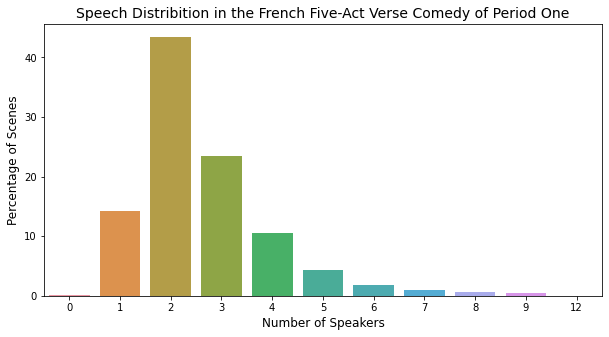

In [24]:
plot_speech_distribution(speech_distribution_by_period(french_period_one), 
                         'Speech Distribition in the French Five-Act Verse Comedy of Period One')

In [25]:
speech_distribution_by_period(french_period_one)

,0,1,2,3,4,5,6,7,8,9,12
number_of_speakers,,,,,,,,,,,
percentage_of_scenes,0.06,14.16,43.43,23.42,10.6,4.39,1.86,0.91,0.68,0.48,0.01


N.Gillet de la Tessonnerie's *Le Campagnard* (1657) and Noël Lebreton, sieur de Hauteroche's *Crispin musicien* (1674) have scenes with no speakers.

In [26]:
np.sum(speech_distribution_by_period(french_period_one).values[0][7:])

2.08

### Speech Distribution in the French Five-Act Comedy In Verse in Period Two

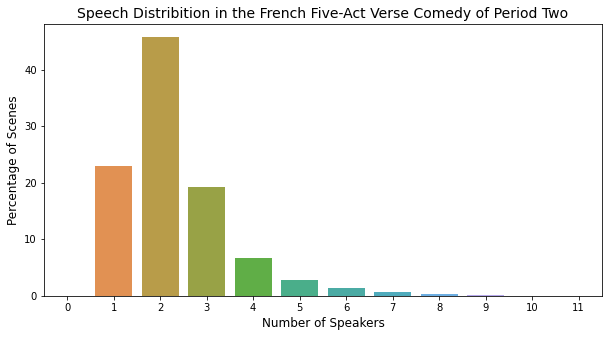

In [27]:
plot_speech_distribution(speech_distribution_by_period(french_period_two), 
                         'Speech Distribition in the French Five-Act Verse Comedy of Period Two')

In [28]:
speech_distribution_by_period(french_period_two)

,0,1,2,3,4,5,6,7,8,9,10,11
number_of_speakers,,,,,,,,,,,,
percentage_of_scenes,0.02,23.01,45.78,19.17,6.73,2.71,1.3,0.74,0.39,0.12,0.02,0.02


Marc-Antoine-Jacques Rochon de Chabannes's *Le Jaloux* (1784) has a scene with no speakers

In [29]:
np.sum(speech_distribution_by_period(french_period_two).values[0][7:])

1.29

### Speech Distribution in the French Five-Act Comedy In Verse in Period Three

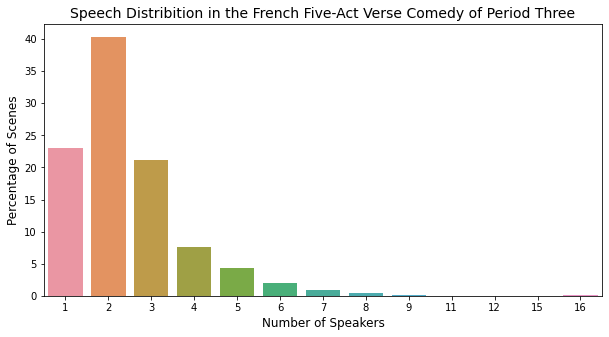

In [30]:
plot_speech_distribution(speech_distribution_by_period(french_period_three), 
                         'Speech Distribition in the French Five-Act Verse Comedy of Period Three')

In [31]:
speech_distribution_by_period(french_period_three)

,1,2,3,4,5,6,7,8,9,11,12,15,16
number_of_speakers,,,,,,,,,,,,,
percentage_of_scenes,23.01,40.33,21.09,7.59,4.31,1.96,0.88,0.5,0.18,0.04,0.04,0.02,0.05


In [32]:
np.sum(speech_distribution_by_period(french_period_three).values[0][6:])

1.71

### Speech Distribution in the Russian Five-Act Comedy In Verse in The Tentative Period One

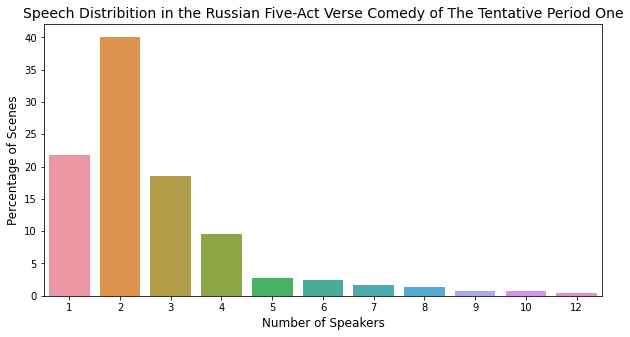

In [33]:
plot_speech_distribution(speech_distribution_by_period(russian_period_one), 
                         'Speech Distribition in the Russian Five-Act Verse Comedy of The Tentative Period One')

In [34]:
speech_distribution_by_period(russian_period_one)

,1,2,3,4,5,6,7,8,9,10,12
number_of_speakers,,,,,,,,,,,
percentage_of_scenes,21.84,40.06,18.58,9.53,2.79,2.44,1.7,1.29,0.71,0.71,0.36


In [35]:
round(np.sum(speech_distribution_by_period(russian_period_one).values[0][6:]), 2)

4.77

### Speech Distribution in the Russian Five-Act Comedy In Verse in The Tentative Period One

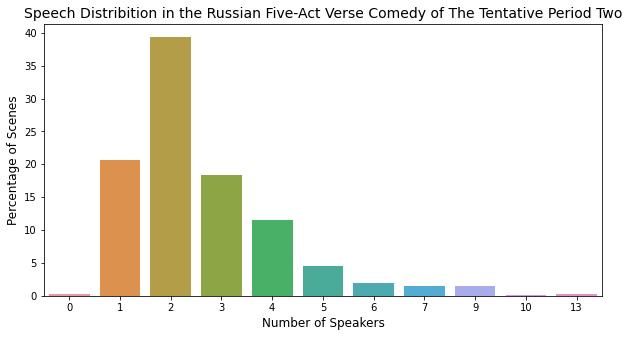

In [36]:
plot_speech_distribution(speech_distribution_by_period(russian_period_two), 
                         'Speech Distribition in the Russian Five-Act Verse Comedy of The Tentative Period Two')

Note that in the Russian corpus there is a comedy that has zero speakers in a scene, Boris Fedorov's *Chudnya vstrechi* (1818).

In [37]:
speech_distribution_by_period(russian_period_two)

,0,1,2,3,4,5,6,7,9,10,13
number_of_speakers,,,,,,,,,,,
percentage_of_scenes,0.3,20.66,39.36,18.39,11.45,4.58,1.99,1.42,1.45,0.17,0.22


### Comparison of The Russian and French Five-Act Comedies in Verse:
1. The mean number of dramatic characters is the Russian five-act comedy in verse of the tentative Period One (11.50) was lower than the mean number of dramatic characters in the French Comedies of Period One. However, it was higher than the mean number of dramatic characters in the French Comedies of Period Two (10.64). In the tentative Period Two, the mean number of dramatic characters (14.70) was higher than the mean number of dramatic characters in French Comedy in Period Three (11.96).
2. The mean mobility coefficient of the Russian five-act comedy in verse of the tentative Period One (53.17) was higher than the mean mobility coefficient of the French Period One (41.82), Period Two (49.56). The mean mobility coefficient of the Russian tentative Period Three (61.60) was higher than the French Period Three (54.31).
3. The standard range of the Russian comedy in the tentative Period One (1.48) and in the tentative Period Two (1.52) was higher than the standard range of the French five-act comedy in verse of all periods (1.23 in Period One, 1.12 in Period Two, and 1.33 in Period Three). 
4. The mean percentage of non-dialogues in the Russian tentative Periods One (59.94%) and Two (60.64%) was higher than the mean percentage of non-dialogues in the French comedies of all periods (56.11% in Period One, 53.50% in Period Two, and 58.12% in Period Three).
5. The mean percentage of polylogues in the Russian tentative Period One (38.11%) is lower than the percentage of polylogues in the French Period One (43.81%), however, it is higher than the percentage of polylogues in the French Period Two (31.37%). The percentage of polylogues in the Russian tentative Period Two (39.68%) is higher than the percentage of polylogues in the French Period Three.
6. The mean percentage of monologues in the Russian tentative Period One (21.84%) is higher than the percentage of monologues in the French Period One (13.18%) but it is lower than the mean percentage of monologues in the French Period Two (22.08%). In the Russian tentative Period Two, the percentage of monologues (20.65%) is slightly higher but very close to the percentage of monologues in the French Period Three (20.35%).
7. The mean coefficient of unused dramatic characters is higher in the Russian tentative Periods One (19.04) and Two (21.40) than in all French periods (12.17 in Period One, 12.75 in Period Two, and 13.74 in Period Three).
8. The mean percentage of discontinuous scenes in the Russian tentative Period One (6.05) was lower than the mean percentage of discontinuous scenes in the French Period One (13.37) and Period Two (6.88). However, the mean percentage of discontinuous scenes was higher in the Russian tentative Period Two (6.55) than in the French Period Three (5.83).
9. The maximum number of speaking characters in the Russian tentative Period One is 12, which is the same the maximum number of speaking characters in the French Period One and is higher than the maximum number of speaking characters in the French Period Two (11). However, in the Russian tentative Period One, 4.77% of the scenes have over 6 speakers, whereas in the French Period One (2.08%) and in the French Period Two (1.29%) have over 6 speakers. In the Russian tentative Period Two, the maximum number of speakers is 13, which is lower than the maximum number of speakers in the French Period Three (16). Yet, the percentage of the scenes with more than 6 speakers in the Russian tentative Period Two is 5.25% and in the French Period Three is 1.71%. In the French comedy of Periods One and Two, there are scenes with no speakers. In the Russian tentative Period Two, there is a comedy with a scene without any speakers.

### Contrastive Material

### William Shakespeare (1582 - 1616)

In [38]:
shakespeare_summary = pd.DataFrame(shakespeare_df.describe().loc['mean', features]).round(2)
                       #pd.DataFrame(goldoni_df.describe().loc['mean', features]).round(2)], axis=1)
shakespeare_summary.columns = ['Shakespeare']

In [39]:
shakespeare_summary

,Shakespeare
num_present_characters,25.83
mobility_coefficient,78.00
standard_range,1.33
percentage_non_dialogues,61.76
percentage_polylogues,37.85
percentage_monologues,23.56
coefficient_unused,40.99
discontinuous_scenes,19.35


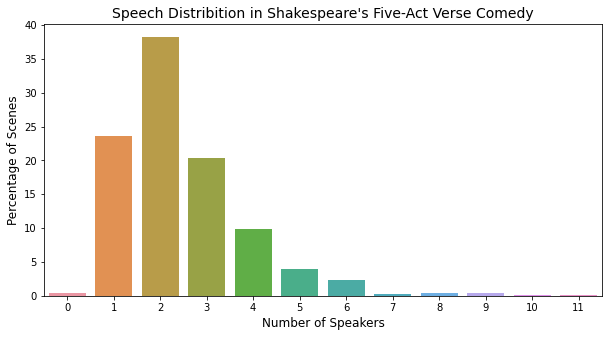

In [40]:
plot_speech_distribution(speech_distribution_by_period(shakespeare_df), 
                         'Speech Distribition in Shakespeare\'s Five-Act Verse Comedy')

### Comparison of Shakespeare's Five-Act Verse Comedies With The Russian, French, and Goldoni's Comedies:
1. The mean number of dramatic characters in Shakespeare's five-act verse comedies (25.83) is the highest observed in our material (French, Russian, and Contrastive).
2. The mean mobility coefficient in Shakespeare's comedies is the highest in our material (78).
3. The mean percentage of non-dialogues in Shakespeare's comedies is the highest observed (61.76%).
4. The mean percentage of monologues is also the highest in our material (23.56%).
5. The mean coefficient of unused dramatic characters is the highest observed (40.99%). The second highest coefficient of unused dramatic characters (in Goldoni, 17.28 does not come even close to that of Shakespeare). There are many dramatic characters who appear on stage but do not speak.
6. The mean percentage of discontinuous scenes in Shakespeare's comedies (19.35%) is the highest in our material.
7. The mean percentage of polylogues (37.85%) is slightly higher than that in the French Period Three (37.69) and lower than that in the Russian tentative Periods One (38.11%) and Two (39.68%).
8. The standard range of the speaking characters (1.33) is the same as the standard range of the speaking characters in the French Period Three. It is lower than in the Russian tentative Periods One (1.48) and Two (1.54). 
9. The maximum number of speaking dramatic characters is 11, which is the same as the maximum number of speakers in the French comedy of Period Two. In the French Periods One and Three, the maximum number of speakers is higher (12 and 16 respectively). In the Russian tentative Periods One and Two, the maximum number of speakers is also higher (12 and 13).
17. In Shakespeare's comedies, there are scenes with no speakers (cf. in the French comedy of Periods One and Two, there are scenes with no speakers. In the Russian tentative Period Two, there is a comedy with a scene without any speakers).

### Carlo Goldoni (1707 - 1793)

In [41]:
goldoni_summary = pd.DataFrame(goldoni_df.describe().loc['mean', features]).round(2)
goldoni_summary.columns = ['Goldoni']

In [42]:
goldoni_summary

,Goldoni
num_present_characters,11.88
mobility_coefficient,62.25
standard_range,1.21
percentage_non_dialogues,58.64
percentage_polylogues,38.74
percentage_monologues,19.65
coefficient_unused,17.28
discontinuous_scenes,9.80


### Speech Distribution in Carlo Goldoni's Five-Act Comedies in Verse

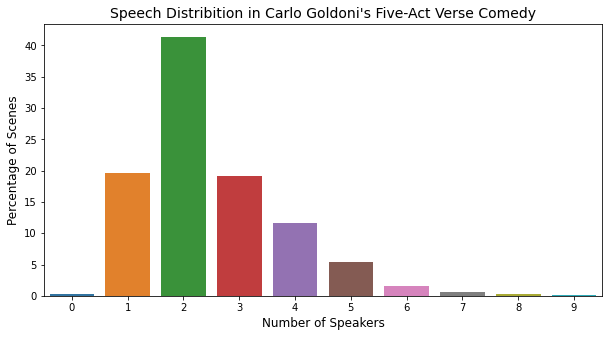

In [43]:
plot_speech_distribution(speech_distribution_by_period(goldoni_df), 
                         'Speech Distribition in Carlo Goldoni\'s Five-Act Verse Comedy')

In [44]:
speech_distribution_by_period(goldoni_df)

,0,1,2,3,4,5,6,7,8,9
number_of_speakers,,,,,,,,,,
percentage_of_scenes,0.25,19.65,41.36,19.2,11.6,5.41,1.5,0.53,0.36,0.14


In Goldoni's comedy I morbinosi, there is indeed a ball scene where no dramatic characters speak.

### Comparison of Goldoni's Five-Act Verse Comedies With The Russian and French Comedies:
1. The mean number of dramatic characters in Goldoni's five-act verse comedies was 11.88, which is close to the mean number of dramatic characters in the French Period One (11.81), Period Three (11.96), and the Russian tentative Period One (11.50).It is much lower than than in Shakespeare's comedies (25.83).
2. The mean mobility coefficient in Goldoni's comedies is 62.25, which is higher than the mean mobility coefficient in all periods of the French and Russian five-act comedy in verse. However, the Russian tentative Period Two comes close with the mean mobility coefficient of 61.60. Shakespeare still has a much higher mean mobility coefficient of 78.
3. The standard range of the speaking dramatic characters in Goldoni's comedies (1.21) is low: it is lower than the standard range in all tentative periods of the Russian comedy (1.48 and 1.54), lower than in Shakespeare, and lower than the standard range of the French comedy in Periods One (1.12) and Three (1.33). However, it is higher than the standard range of the French comedy of Period Two (1.12).
4. The percentage of non-dialogues (58.64) is lower than that in the Russian comedy of both tentative periods (59.94% and 60.64%). It is also lower than in Shakespeare (61.76%). However, the percentage of non-dialogues in Goldoni's comedies is higher than that in the French comedies of Periods One (56.11%) and Two (53.50%).
5. The percentage of polylogues in Goldoni's comedies (38.74%) is close to the percentage of polylogues in the Russian comedies of the tentative Period One (38.11%) and Two (39.68%). It is also higher than in Shakespeare's comedies (37.85%). The percentage of polylogues in Goldoni's comedies is higher than that in the French Period One (37.69%) and Period Two (31.37%). However, it is lower than that of the French Period Three (58.12%).
6. The percentage of monologues in Goldoni (19.65%) is lower than the percentage of monologues in the Russian comedies of the two tentative periods (21.84% and 20.65%). It is lower than that in Shakespeare's comedies (23.56%). It is also lower than the percentage of monologues in the French Periods Two (22.08%) and Three (20.35%).  it is higher than the percentage of monologues in the French Period One (13.18). 
7. The coefficient of unused dramatic characters in Goldoni's comedies (17.28%) is higher than that of the French comedies in all periods (12.17% in Period One, 12.75% in Period Two, and 13.74% in Period Three). It is, however, lower than that of the Russian comedies of all tentative periods (19.05 and 21.40). The coefficient is much lower in Goldoni's comedies than in Shakespeare's comedies (40.99).
8. The percentage of discontinuous scenes in Goldoni (9.8) is higher than in both Russian tentative periods (6.05% and 6.55%). It is also higher than that of the French comedies of Periods Two (6.88%) and Three (5.83%). Yet, it is lower than than that in the French Period One (13.37%).

## Euclidean Distances Between Russian, French, Shakespeare's, and Goldoni's Five-Act Comedies in Verse

In [146]:
normalized_french = normalize(french_summary_comedies.iloc[:-2,:], axis=0)
normalized_russian = normalize(russian_summary_comedies.iloc[:-2,:], axis=0)
normalized_shakespeare = normalize(shakespeare_summary.iloc[:-2,:], axis=0)
normalized_shakespeare = normalize(shakespeare_summary.iloc[:-2,:], axis=0)
normalized_goldoni = normalize(goldoni_summary.iloc[:-2,:], axis=0)

In [152]:
print('Euclidean distances between the Russian five-act comedies and other groups:')
print('\n\t\u2022 the Russian tentative Period One and the French Period One:',
      round(euclidean_distances(normalized_russian[:, 0].reshape(1, -1),
                  normalized_french[:, 0].reshape(1, -1))[0][0], 3))
print('\t\u2022 the Russian tentative Period One and the French Period Two:',
      round(euclidean_distances(normalized_russian[:, 0].reshape(1, -1),
                  normalized_french[:, 1].reshape(1, -1))[0][0], 3))
print('\t\u2022 the Russian tentative Period One and the French Period Three:',
      round(euclidean_distances(normalized_russian[:, 0].reshape(1, -1),
                  normalized_french[:, 2].reshape(1, -1))[0][0], 3))
print('\n\t\u2022 the Russian tentative Period Two and the French Period One:',
      round(euclidean_distances(normalized_russian[:, 1].reshape(1, -1),
                  normalized_french[:, 0].reshape(1, -1))[0][0], 3))
print('\t\u2022 the Russian tentative Period Two and the French Period Two:',
      round(euclidean_distances(normalized_russian[:, 1].reshape(1, -1),
                  normalized_french[:, 1].reshape(1, -1))[0][0], 3))
print('\t\u2022 the Russian tentative Period Two and the French Period Three:',
      round(euclidean_distances(normalized_russian[:, 1].reshape(1, -1),
                  normalized_french[:, 2].reshape(1, -1))[0][0], 3))
print('\n\t\u2022 the Russian tentative Period One and Shakespeare:',
      round(euclidean_distances(normalized_russian[:, 0].reshape(1, -1),
                  normalized_shakespeare[:, 0].reshape(1, -1))[0][0], 3))
print('\t\u2022 the Russian tentative Period Two and Shakespeare:',
      round(euclidean_distances(normalized_russian[:, 1].reshape(1, -1),
                  normalized_shakespeare[:, 0].reshape(1, -1))[0][0], 3))
print('\n\t\u2022 the Russian tentative Period One and Goldoni:',
      round(euclidean_distances(normalized_russian[:, 0].reshape(1, -1),
                  normalized_goldoni[:, 0].reshape(1, -1))[0][0], 3))
print('\t\u2022 the Russian tentative Period Two and Goldoni:',
      round(euclidean_distances(normalized_russian[:, 1].reshape(1, -1),
                  normalized_goldoni[:, 0].reshape(1, -1))[0][0], 3))

Euclidean distances between the Russian five-act comedies and other groups:

	• the Russian tentative Period One and the French Period One: 0.15
	• the Russian tentative Period One and the French Period Two: 0.051
	• the Russian tentative Period One and the French Period Three: 0.027

	• the Russian tentative Period Two and the French Period One: 0.183
	• the Russian tentative Period Two and the French Period Two: 0.077
	• the Russian tentative Period Two and the French Period Three: 0.045

	• the Russian tentative Period One and Shakespeare: 0.204
	• the Russian tentative Period Two and Shakespeare: 0.141

	• the Russian tentative Period One and Goldoni: 0.088
	• the Russian tentative Period Two and Goldoni: 0.034


In [154]:
print('\nEuclidean distances between the French five-act comedies and other groups:')
print('\n\t\u2022 the French Period One and Shakespeare:',
      round(euclidean_distances(normalized_shakespeare[:, 0].reshape(1, -1),
                  normalized_french[:, 0].reshape(1, -1))[0][0], 3))
print('\t\u2022 the French Period Two and Shakespeare:',
      round(euclidean_distances(normalized_shakespeare[:, 0].reshape(1, -1),
                  normalized_french[:, 1].reshape(1, -1))[0][0], 3))
print('\t\u2022 the French Period Three and Shakespeare:',
      round(euclidean_distances(normalized_shakespeare[:, 0].reshape(1, -1),
                  normalized_french[:, 2].reshape(1, -1))[0][0], 3))
print('\n\t\u2022 the French Period One and Goldoni:',
      round(euclidean_distances(normalized_goldoni[:, 0].reshape(1, -1),
                  normalized_french[:, 0].reshape(1, -1))[0][0], 3))
print('\t\u2022 the French Period Two and Goldoni:',
      round(euclidean_distances(normalized_goldoni[:, 0].reshape(1, -1),
                  normalized_french[:, 1].reshape(1, -1))[0][0], 3))
print('\t\u2022 the French Period Three and Goldoni:',
      round(euclidean_distances(normalized_goldoni[:, 0].reshape(1, -1),
                  normalized_french[:, 2].reshape(1, -1))[0][0], 3))


Euclidean distances between the French five-act comedies and other groups:

	• the French Period One and Shakespeare: 0.306
	• the French Period Two and Shakespeare: 0.184
	• the French Period Three and Shakespeare: 0.182

	• the French Period One and Goldoni: 0.199
	• the French Period Two and Goldoni: 0.09
	• the French Period Three and Goldoni: 0.063


In [155]:
print('\nEuclidean distance between Shakespeare and Goldoni:',
     round(euclidean_distances(normalized_shakespeare[:, 0].reshape(1, -1),
                  normalized_goldoni[:, 0].reshape(1, -1))[0][0], 3))


Euclidean distance between Shakespeare and Goldoni: 0.146
